**DATOS BASE**

Descargamos del [EFFIS](https://forest-fire.emergency.copernicus.eu/) (European Forest Fire Information System) la superficie quemada en formato shapefile:
- [Burn Areas database](https://maps.effis.emergency.copernicus.eu/effis?service=WFS&request=getfeature&typename=ms:modis.ba.poly&version=1.1.0&outputformat=SHAPEZIP)

Descargamos de eurostat ([GISCO](https://ec.europa.eu/eurostat/web/gisco/overview)) un shapefile para obtener el nombre en inglés de los países y sus códigos internacionales:
- [Countries](https://ec.europa.eu/eurostat/web/gisco/geodata/administrative-units/countries)

In [1]:
import datetime as dt
import geopandas as gpd
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Cargamos el shapefile de EFFIS con geopandas

shp_effis = gpd.read_file('~/Descargas/effis_layer/modis.ba.poly.shp')
shp_effis.head()

,id,FIREDATE,LASTUPDATE,COUNTRY,PROVINCE,COMMUNE,AREA_HA,BROADLEA,CONIFER,MIXED,SCLEROPH,TRANSIT,OTHERNATLC,AGRIAREAS,ARTIFSURF,OTHERLC,PERCNA2K,CLASS,geometry
0,264477,2000-09-20 00:00:00,2025-03-28 15:01:38.620495,EL,??????,???????? ????????? ?????,981,2.1472392638034616,0,0,5.4192229038849264,73.51738241308041,1.431492842535641,16.46216768915987,1.0224948875254578,0,32.02719647413729,FireSeason,"POLYGON ((24.10056 38.66232, 24.10079 38.65254..."
1,260352,2000-07-31 00:00:00,2000-12-31 12:10:11.414,IT,Crotone,Roccabernarda,56,0,0,0,0,0,58.49056603762549,41.50943396218583,0,0,99.99999999999997,FireSeason,"POLYGON ((16.84555 39.15941, 16.84656 39.15743..."
2,260396,2000-08-25 00:00:00,2000-12-31 12:10:11.414,IT,Crotone,Pallagorio,413,61.36919315401923,0,0,0,0,0,38.63080684595633,0,0,98.7552636258531,FireSeason,"POLYGON ((16.89034 39.33069, 16.89195 39.32436..."
3,260398,2000-07-15 00:00:00,2000-12-31 12:10:11.414,IT,Cosenza,Corigliano-Rossano,88,43.678160919490026,0,0,0,0,0,56.32183908039503,0,0,0,FireSeason,"POLYGON ((16.70885 39.57951, 16.71165 39.57865..."
4,259734,2000-09-02 00:00:00,2000-12-31 12:10:11.414,PT,Beiras e Serra da Estrela,Alvendre,54,0,0,0,0,21.81818181814215,45.45454545446281,32.727272727213226,0,0,0,FireSeason,"POLYGON ((-7.2476 40.59114, -7.24515 40.59178,..."


In [3]:
# Comprobamos y vemos que todos los campos son strings: no se reconcen números ni fechas

shp_effis.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 92772 entries, 0 to 92771
Data columns (total 19 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   id          92772 non-null  object  
 1   FIREDATE    92772 non-null  object  
 2   LASTUPDATE  92772 non-null  object  
 3   COUNTRY     92764 non-null  object  
 4   PROVINCE    92772 non-null  object  
 5   COMMUNE     92772 non-null  object  
 6   AREA_HA     92772 non-null  object  
 7   BROADLEA    92121 non-null  object  
 8   CONIFER     92121 non-null  object  
 9   MIXED       92121 non-null  object  
 10  SCLEROPH    92121 non-null  object  
 11  TRANSIT     92121 non-null  object  
 12  OTHERNATLC  92121 non-null  object  
 13  AGRIAREAS   92121 non-null  object  
 14  ARTIFSURF   92121 non-null  object  
 15  OTHERLC     92121 non-null  object  
 16  PERCNA2K    92772 non-null  object  
 17  CLASS       92772 non-null  object  
 18  geometry    92772 non-null  geometry
d

**FILTRO DE PAÍSES UE Y ENTORNO**

In [4]:
# Países de nuestro shapefile

paises = shp_effis.COUNTRY.unique()
print(f'{len(paises)} países en total:\n\n{paises}')

52 países en total:

['EL' 'IT' 'PT' 'ES' 'RO' 'MK' 'HR' 'RS' 'FR' 'BG' 'CY' 'TR' 'KS' 'HU'
 'AT' 'BA' 'AL' 'FI' 'ME' 'CZ' 'LV' 'PL' 'LT' 'UK' 'DK' 'DE' 'SK' 'SI'
 'CH' 'EE' 'IE' 'NO' None 'NL' 'DZ' 'BE' 'IL' 'MA' 'TN' 'LB' 'JO' 'PS'
 'SE' 'SY' 'LY' 'GE' 'MT' 'UA' 'EG' 'MD' 'GB' 'GR']


In [5]:
# Cargamos shapefile con datos de todos los países del mundo

df_paises = gpd.read_file('~/Descargas/GISCO_SHP/CNTR_RG_20M_2024_4326.shp')
df_paises.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 260 entries, 0 to 259
Data columns (total 12 columns):
 #   Column     Non-Null Count  Dtype   
---  ------     --------------  -----   
 0   CNTR_ID    260 non-null    object  
 1   CNTR_NAME  260 non-null    object  
 2   NAME_ENGL  260 non-null    object  
 3   NAME_FREN  241 non-null    object  
 4   ISO3_CODE  260 non-null    object  
 5   SVRG_UN    260 non-null    object  
 6   CAPT       233 non-null    object  
 7   EU_STAT    260 non-null    object  
 8   EFTA_STAT  260 non-null    object  
 9   CC_STAT    260 non-null    object  
 10  NAME_GERM  240 non-null    object  
 11  geometry   260 non-null    geometry
dtypes: geometry(1), object(11)
memory usage: 24.5+ KB


In [6]:
# Filtramos por los 27 + Suiza, Noruega, Reino Unido y países de los Balcanes
'''
Países UE:
https://european-union.europa.eu/principles-countries-history/eu-countries_es#header_countries_list

'''
eu_countries = [
    "Germany",
    "Austria",
    "Belgium",
    "Bulgaria",
    "Czechia",
    "Cyprus",
    "Croatia",
    "Denmark",
    "Slovakia",
    "Slovenia",
    "Spain",
    "Estonia",
    "Finland",
    "France",
    "Greece",
    "Hungary",
    "Ireland",
    "Italy",
    "Latvia",
    "Lithuania",
    "Luxembourg",
    "Malta",
    "Netherlands",
    "Poland",
    "Portugal",
    "Romania",
    "Sweden",
    'Switzerland',
    'Norway','United Kingdom',
    'North Macedonia', 'Serbia', 'Albania', 'Bosnia and Herzegovina', 'Montenegro', 'Kosovo'
]


def filtro_paises(paises:list):
    lista_codes = []
    for pais in paises:
        resultado = df_paises.loc[df_paises.NAME_ENGL == pais, 'CNTR_ID']
        code = resultado.values[0] if len(resultado) > 0 else print(f'No se encuentra {pais}')
        lista_codes.append(code)
    lista_codes.append('KS') # Código para Kosovo, podemos comprobarlo visualmente abriendo los shapes en un SIG

    return shp_effis[shp_effis.COUNTRY.isin(lista_codes)]

df_paises = df_paises[df_paises.NAME_ENGL.isin(eu_countries)]
effis_eu = filtro_paises(eu_countries)

No se encuentra Kosovo


In [7]:
# Creamos un nuevo campo para el código del país (COUNTRY_ID) y sustituimos el campo 'COUNTRY' con el nombre en inglés

def nombre_pais(country_codes):
    lista_paises = []
    for code in country_codes:
        resultado = df_paises.loc[df_paises.CNTR_ID == code, 'NAME_ENGL']
        pais = resultado.values[0] if len(resultado) > 0 else 'Kosovo'
        lista_paises.append(pais)

    return lista_paises

effis_eu['COUNTRY_ID'] = effis_eu.COUNTRY
effis_eu['COUNTRY'] = nombre_pais(effis_eu.COUNTRY)

/usr/lib/python3.13/site-packages/geopandas/geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


**CÁLCULO DEL CENTROIDE Y COORDENADAS**

In [8]:
# Reproyectamos capa, calculamos centroides y extraemos coordenadas

effis_eu = effis_eu.to_crs(4326)
effis_eu['LAT'], effis_eu['LON'] = effis_eu.centroid.y, effis_eu.centroid.x

/tmp/ipykernel_16370/3257089057.py:4: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  effis_eu['LAT'], effis_eu['LON'] = effis_eu.centroid.y, effis_eu.centroid.x


In [9]:
# Comprobamos longitud para las islas atlánticas

effis_eu[effis_eu.LON < -11].groupby('COUNTRY').PROVINCE.value_counts()

COUNTRY   PROVINCE                  
Portugal  Região Autónoma da Madeira    49
          Região Autónoma dos Açores     4
Spain     Tenerife                      24
          Gran Canaria                  11
          La Palma                       8
          La Gomera                      3
Name: count, dtype: int64

In [10]:
# Comprobamos latitud para isla La Rèunion

effis_eu[effis_eu.LAT < 0].groupby('COUNTRY').PROVINCE.value_counts()

COUNTRY  PROVINCE  
France   La Réunion    1
Name: count, dtype: int64

In [11]:
# Eliminamos islas menores y archipiélagos

effis_eu = effis_eu.loc[(effis_eu.LAT > 0) & (effis_eu.LON > -11), :]

**CONVERSIÓN FECHA Y CÁLCULO DURACIÓN Y DIAS JULIANOS**

In [13]:
# Pasamos las columnas de inicio de incendio y última actualización a datetime 
effis_eu.FIREDATE = pd.to_datetime(effis_eu.FIREDATE, format='ISO8601')
effis_eu.LASTUPDATE = pd.to_datetime(effis_eu.LASTUPDATE, format='ISO8601')

# Eliminamos los incendios de 2025
effis_eu = effis_eu[effis_eu.FIREDATE.dt.year < 2025]

# Calculamos la duración del incendio
effis_eu['DURATION'] = effis_eu.LASTUPDATE - effis_eu.FIREDATE

In [14]:
# Revisamos los datos de 'DURATION', pero no parecen coincidir con la duración del incendio
# Probablemente 'LASTUPDATE' esté ligado a la fecha de extinción del incendio, esto es, 
# cuando la autoridad competente lo determina, o última fecha que se detecta la 'huella' del incendio.
# En cualquier caso, no nos sirve este dato ya que se buscaba valorar la velocidad de propagación 

effis_eu.DURATION.dt.days.describe()

count    58540.000000
mean      1117.631500
std       1917.087137
min        -24.000000
25%          9.000000
50%        168.000000
75%       1154.000000
max       8955.000000
Name: DURATION, dtype: float64

In [15]:
# Calculamos el día juliano pero como si todos los años fueran bisiestos

def dia_juliano_bisiesto(serie):
    dias_meses = [0,31,29,31,30,31,30,31,31,30,31,30]
    lista_dias = []
    for valor in serie:
        dia_juliano = 0
        mes = valor.month
        for index in range(mes):
            dia_juliano += dias_meses[index]
        dia_juliano += valor.day
        lista_dias.append(dia_juliano)
    return lista_dias

effis_eu['DAY_YEAR'] = dia_juliano_bisiesto(effis_eu.FIREDATE)

**CONVERSIÓN DE VARIABLES NUMÉRICAS**

In [16]:
effis_eu.AREA_HA = effis_eu.AREA_HA.astype(int)

# Las siguientes variables hacen referencia al tipo de superficie quemada
# expresada en porcentaje del área del incendio

var_float = ['BROADLEA', 'CONIFER', 'MIXED', 'SCLEROPH', 'TRANSIT',
       'OTHERNATLC', 'AGRIAREAS', 'ARTIFSURF', 'OTHERLC']

for variable in var_float:
    effis_eu[variable] = effis_eu[variable].astype(float)

**REORDENAMOS Y LIMPIAMOS**

In [17]:
effis_eu['YEAR'] = effis_eu.FIREDATE.dt.year
effis_eu = effis_eu[['FIREDATE','DAY_YEAR','YEAR',
                    'COUNTRY_ID','COUNTRY','PROVINCE','COMMUNE',
                    'AREA_HA','BROADLEA','CONIFER','MIXED',
                    'SCLEROPH','TRANSIT','OTHERNATLC',
                    'AGRIAREAS','ARTIFSURF','OTHERLC',
                    'LAT','LON']]
effis_eu.info()

<class 'pandas.core.frame.DataFrame'>
Index: 58540 entries, 0 to 87125
Data columns (total 19 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   FIREDATE    58540 non-null  datetime64[ns]
 1   DAY_YEAR    58540 non-null  int64         
 2   YEAR        58540 non-null  int32         
 3   COUNTRY_ID  58532 non-null  object        
 4   COUNTRY     58540 non-null  object        
 5   PROVINCE    58540 non-null  object        
 6   COMMUNE     58540 non-null  object        
 7   AREA_HA     58540 non-null  int64         
 8   BROADLEA    58215 non-null  float64       
 9   CONIFER     58215 non-null  float64       
 10  MIXED       58215 non-null  float64       
 11  SCLEROPH    58215 non-null  float64       
 12  TRANSIT     58215 non-null  float64       
 13  OTHERNATLC  58215 non-null  float64       
 14  AGRIAREAS   58215 non-null  float64       
 15  ARTIFSURF   58215 non-null  float64       
 16  OTHERLC     58215 non-null 

**FILTRO DE GRANDES INCENDIOS FORESTALES**

Porcentaje de grandes incendios en Europa: 	7.04 %
Porcentaje de superficie quemada por GIF: 	65.25 %


COUNTRY
Portugal                  976
Spain                     690
Italy                     430
Bosnia and Herzegovina    333
Greece                    300
Albania                   213
Romania                   184
Montenegro                153
North Macedonia           149
Bulgaria                  148
Croatia                   142
France                    128
United Kingdom             71
Serbia                     51
Ireland                    23
Kosovo                     23
Cyprus                     21
Latvia                     14
Hungary                    12
Poland                     12
Sweden                     11
Norway                      9
Germany                     7
Estonia                     5
Lithuania                   5
Belgium                     3
Finland                     3
Czechia                     2
Slovenia                    2
Denmark                     1
Netherlands                 1
Name: count, dtype: int64

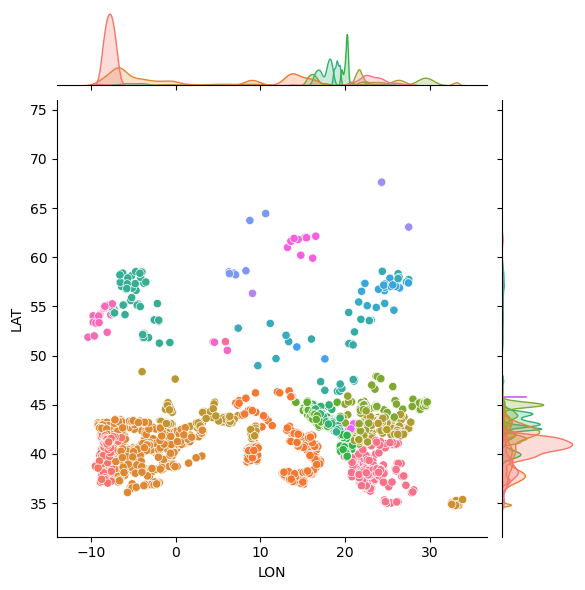

In [18]:
# Filtramos los grandes incendios forestales (GIFs), esto es, incendios a partir de 500 ha
# Guardamos en un dataframe nuevo y reservamos los datos de todos los incendios para comparar después

effis = effis_eu[effis_eu.AREA_HA > 499]

# Porcentaje de GIFs respecto número de incendios (más veremos la evolución de GIFs por países)
print(f'Porcentaje de grandes incendios en Europa: \t{round(effis.AREA_HA.count() / effis_eu.AREA_HA.count()*100, 2)} %')
print(f'Porcentaje de superficie quemada por GIF: \t{round(effis.AREA_HA.sum() / effis_eu.AREA_HA.sum()*100, 2)} %')

# Distribucion de GIFs por países seleccionados
sns.jointplot(effis, x='LON', y='LAT', hue = 'COUNTRY', legend=False);
effis.COUNTRY.value_counts()

**AGRUPACIÓN POR PAÍSES**

In [19]:
# Agrupamos los países para analizar más fácilmente los datos:

# Primero agrupamos los paises con menor número de incendios
seleccion = effis.COUNTRY.value_counts()
paises_min = seleccion[seleccion < 100].index

# Agrupamos los países de los Balcanes
balkans = ['North Macedonia', 'Serbia', 'Albania', 'Bosnia and Herzegovina', 'Montenegro', 'Kosovo', 'Croatia']

# Agrupamos las Islas Británicas
British_Is = ['United Kingdom','Ireland']

# Elimiamos los países redundantes de la lista 'paises_min' para evitar que los categorice como 'Otros'
pais_remove = []
for pais in paises_min:
    if (pais in balkans) or (pais in British_Is):
        pais_remove.append(pais)

paises_min = paises_min.drop(pais_remove)

# Creamos una nueva columna y renombramos los países
effis['GIF_GROUP'] = effis.COUNTRY.replace(paises_min, 'Otros')
effis['GIF_GROUP'] = effis.GIF_GROUP.replace(balkans, 'Balkans')
effis['GIF_GROUP'] = effis.GIF_GROUP.replace(British_Is, 'British_Is')

/tmp/ipykernel_16370/4001195169.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  effis['GIF_GROUP'] = effis.COUNTRY.replace(paises_min, 'Otros')
/tmp/ipykernel_16370/4001195169.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  effis['GIF_GROUP'] = effis.GIF_GROUP.replace(balkans, 'Balkans')
/tmp/ipykernel_16370/4001195169.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the do

GIF_GROUP
Balkans       1064
Portugal       976
Spain          690
Italy          430
Greece         300
Romania        184
Bulgaria       148
France         128
Otros          108
British_Is      94
Name: count, dtype: int64

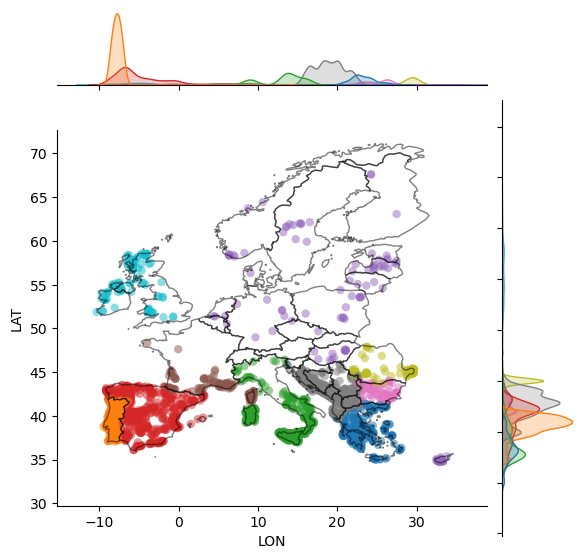

In [20]:
# Y echamos un vistazo a la distribución por países
g = sns.jointplot(effis, x='LON', y='LAT', hue = 'GIF_GROUP', edgecolor='none', legend=False, alpha=0.5)

# Ajustamos para agregar el mapa de los países de fondo
ax = g.ax_joint
zoom = 5
ax.set_xlim(effis.LON.min() - zoom, effis.LON.max() + zoom)
ax.set_ylim(effis.LAT.min() - zoom, effis.LAT.max() + zoom)

# Agregamos el shapefile directamente desde geopandas
df_paises.plot(ax=ax, color='none', edgecolor='k', alpha=0.5);
effis.GIF_GROUP.value_counts()

**AGRUPACIÓN POR PROVINCIA**

Con esta agrupación se pretende evitar las fronteras administrativas, focalizándose en las zonas concretas dónde se producen los grandes incendios.  
Aquí intentaremos responder a la pregunta ¿dónde se producen los grandes incendios?

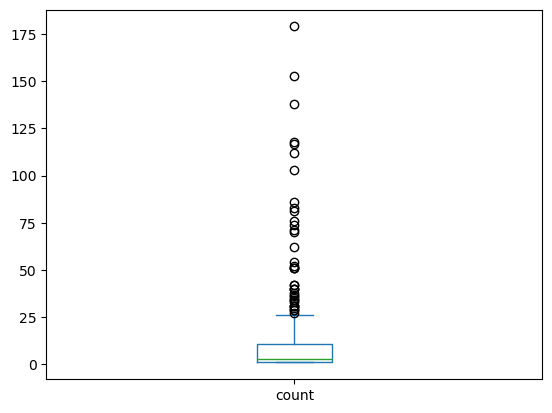

In [21]:
# Vistazo rápido a la distribución de número de incendios por zonas
# Comprobamos que las zonas más afectadas son los outliers de la distribución
# Por tanto, hay áreas de alta incidencia de grandes incendios forestales

effis.PROVINCE.value_counts().plot.box();

In [22]:
# Categorizamos las zonas por número de incendios: al haber una distribución tan grande (de 1 a >175) simplificamos usado una escala logarítmica
provincias = effis.PROVINCE.value_counts()

categorias = {}
for provincia, incendios in provincias.items():
    categorias[provincia] = np.log(incendios).round().astype(int) if incendios > 0 else 0

categorias

{'Beiras e Serra da Estrela': np.int64(5),
 '???? ????': np.int64(5),
 'Tulcea': np.int64(5),
 '???????': np.int64(5),
 '??????': np.int64(5),
 'Ourense': np.int64(5),
 'Douro': np.int64(5),
 'Korcë': np.int64(4),
 'Alto Tâmega': np.int64(4),
 'Viseu Dão Lafões': np.int64(4),
 '???????????': np.int64(4),
 '?????': np.int64(4),
 'Tâmega e Sousa': np.int64(4),
 'Palermo': np.int64(4),
 'Alto Minho': np.int64(4),
 'Médio Tejo': np.int64(4),
 'Agrigento': np.int64(4),
 'León': np.int64(4),
 'Zamora': np.int64(4),
 'Terras de Trás-os-Montes': np.int64(4),
 '????????': np.int64(4),
 'N.A.': np.int64(4),
 'Glamo?': np.int64(4),
 'Região de Coimbra': np.int64(4),
 'Cáceres': np.int64(4),
 'Beira Baixa': np.int64(4),
 '?????????': np.int64(4),
 'Ave': np.int64(4),
 'Splitsko-dalmatinska ?upanija': np.int64(4),
 'Trebinje': np.int64(4),
 '?ibensko-kninska ?upanija': np.int64(4),
 'Região de Leiria': np.int64(3),
 'Asturias': np.int64(3),
 'Durrës': np.int64(3),
 'Pontevedra': np.int64(3),
 'A Co

In [25]:
# Asignamos a cada incendio su categoría, creando para ello una nueva variable

for provincia, categoria in categorias.items():
    effis.loc[effis.PROVINCE == provincia, 'PROV_CAT'] = categoria
effis.PROV_CAT = effis.PROV_CAT.astype(int)

effis.PROV_CAT.value_counts(dropna=False)

/tmp/ipykernel_16370/2152199060.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  effis.PROV_CAT = effis.PROV_CAT.astype(int)


PROV_CAT
4    1280
3    1007
5     920
2     551
1     248
0     116
Name: count, dtype: int64

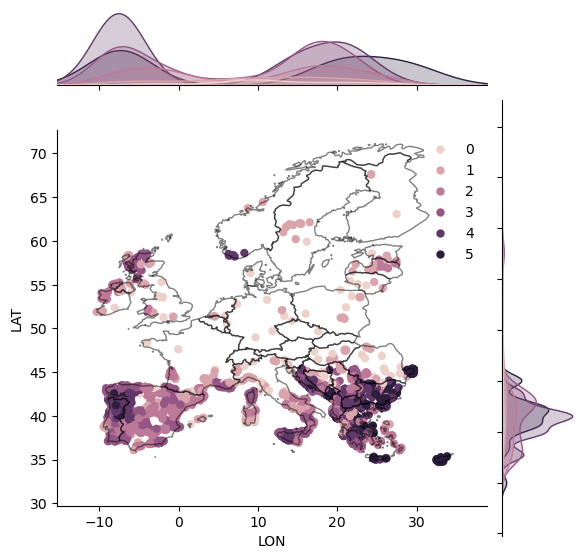

In [26]:
# Y echamos un vistazo a las 'zonas calientes'
g = sns.jointplot(effis, x='LON', y='LAT', hue = 'PROV_CAT', edgecolor='none', legend=True)

# Ajustamos para agregar el mapa de los países de fondo
ax = g.ax_joint
zoom = 5
ax.set_xlim(effis.LON.min() - zoom, effis.LON.max() + zoom)
ax.set_ylim(effis.LAT.min() - zoom, effis.LAT.max() + zoom)
ax.legend(frameon=False)
9
# Agregamos el shapefile directamente desde geopandas
df_paises.plot(ax=ax, color='none', edgecolor='k', alpha=0.5);

**DISTRIBUCIÓN EN EL TIEMPO**

En este apartado intentaremos responder a la pregunta ¿En qué época del año se producen los grandes incendios?

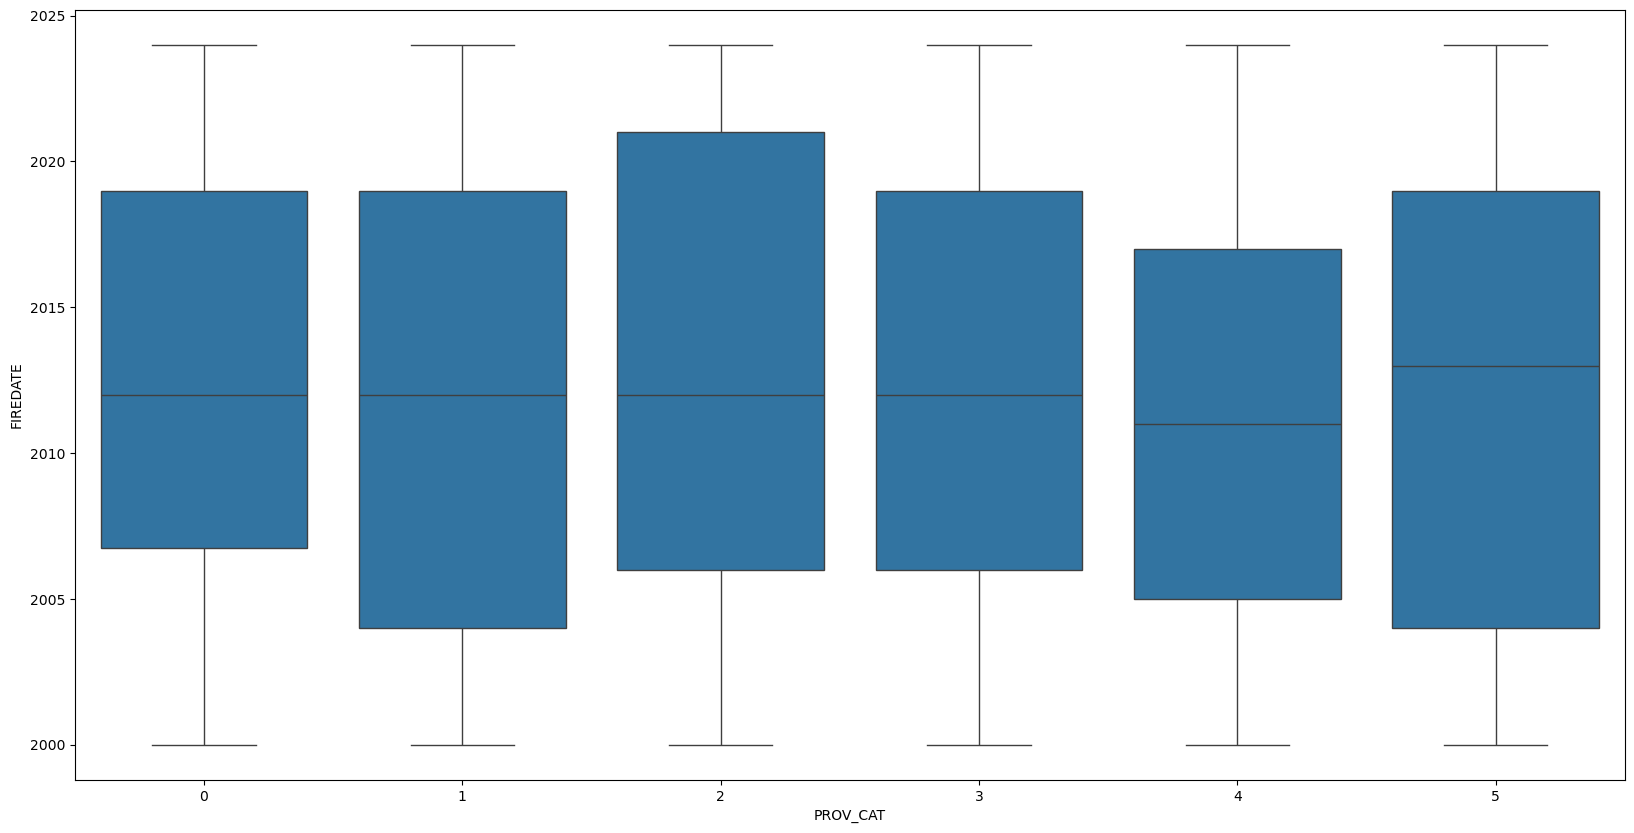

In [27]:
# Distribución por categorías (número de incendios). 
# Aquí vemos que los datos están demasiado agrupados (y las zonas parece no guardar ninguna relación entre ellas)

plt.figure(figsize=(20, 10))
sns.boxplot(effis, x='PROV_CAT', y=effis.FIREDATE.dt.year);

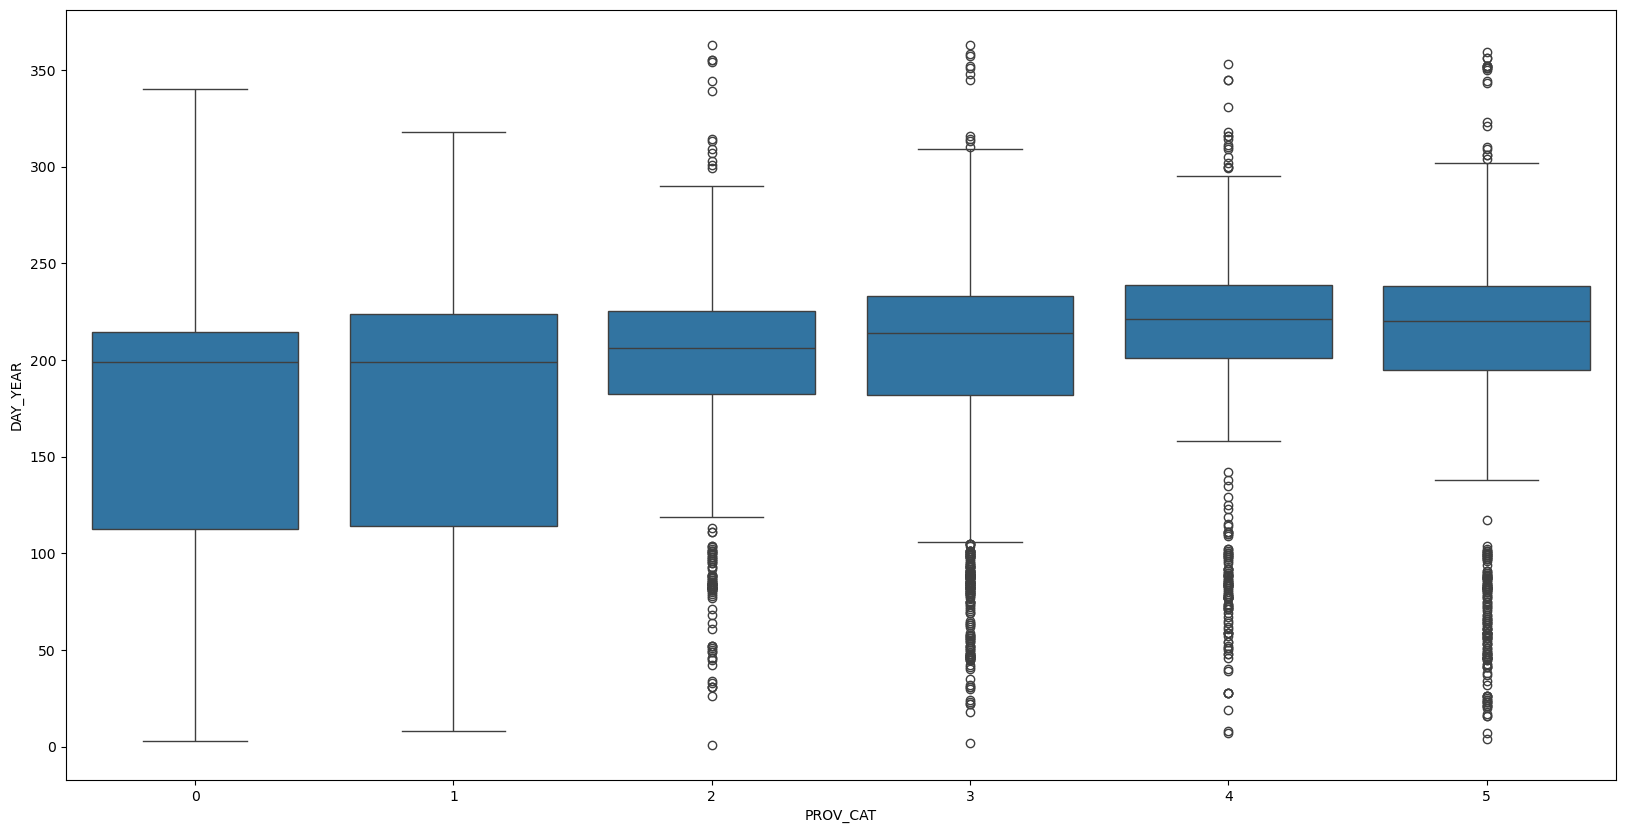

In [28]:
# Aquí sí podemos ver que algunas zonas con alta incidencia de grandes incendios
# los sufren en invierno y primavera

plt.figure(figsize=(20, 10))
sns.boxplot(effis, x='PROV_CAT', y='DAY_YEAR');

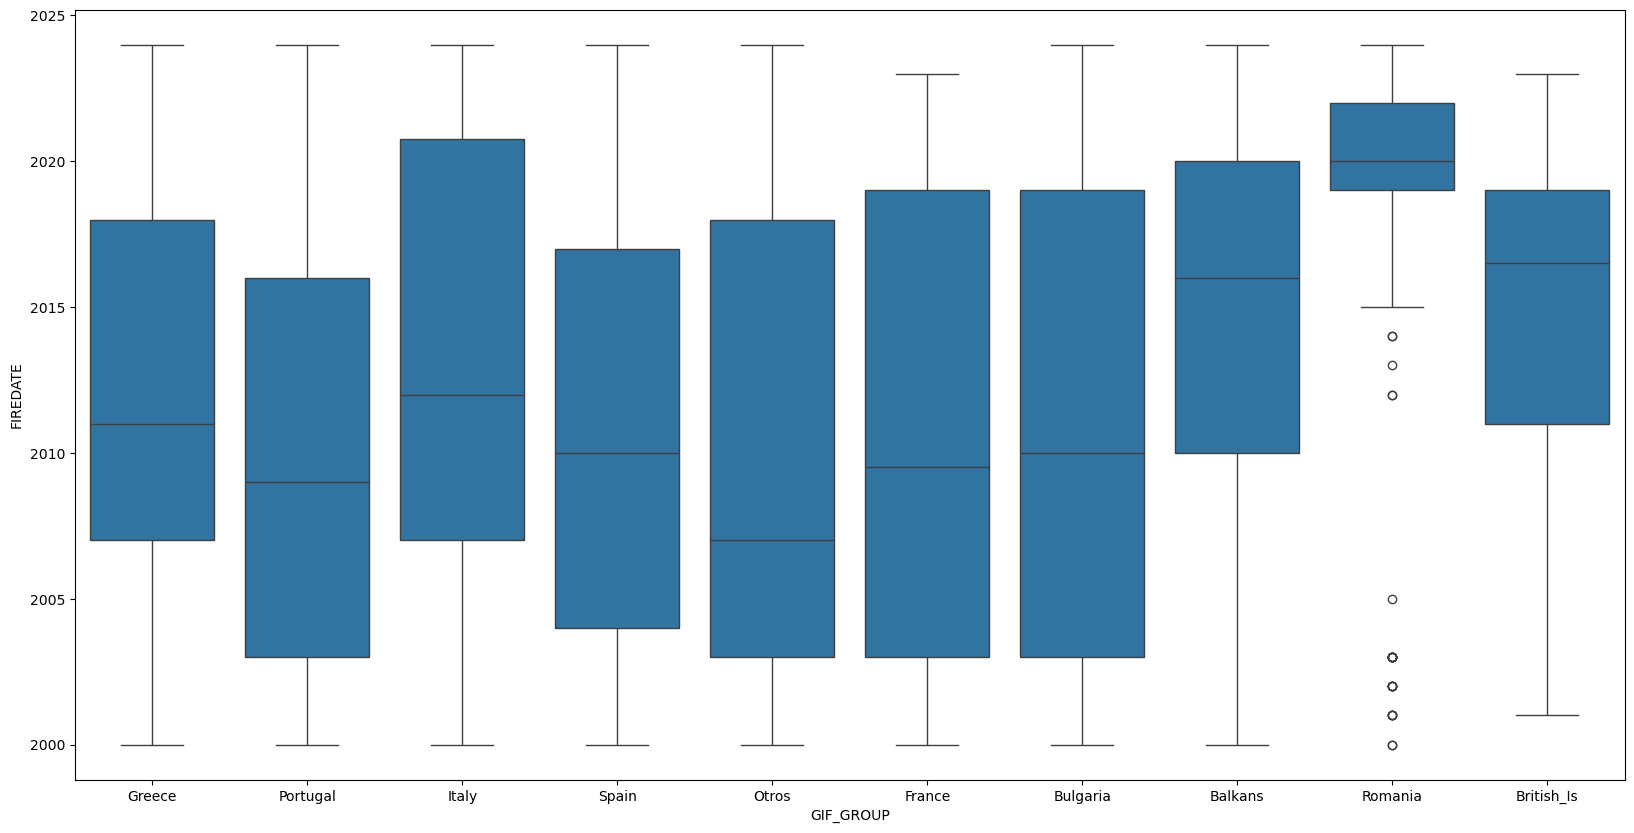

In [29]:
# Distribución por países. Aquí ya vemos por ejemplo que Rumanía tiene un 'problema' reciente, seguido de los Balcanes y las Islas Británicas 

plt.figure(figsize=(20, 10))
sns.boxplot(effis, x='GIF_GROUP', y=effis.FIREDATE.dt.year);

In [30]:
# Veamos ahora como ha evolucionado el porcentaje de grandes incendios por año

# Primero repetimos categorización en el dataframe con todos los incendios
# No podemos repetir filtro de > 100 incendios porque pueden salir países de 'Otros'

grupo_paises = effis.GIF_GROUP.unique()

effis_eu['GIF_GROUP'] = effis_eu.COUNTRY
effis_eu['GIF_GROUP'] = effis_eu.GIF_GROUP.replace(balkans, 'Balkans')
effis_eu['GIF_GROUP'] = effis_eu.GIF_GROUP.replace(British_Is, 'British_Is')
effis_eu.loc[~effis_eu.GIF_GROUP.isin(grupo_paises),'GIF_GROUP'] = 'Otros'

effis_eu.GIF_GROUP.unique()

array(['Greece', 'Italy', 'Portugal', 'Spain', 'Romania', 'Balkans',
       'France', 'Bulgaria', 'Otros', 'British_Is'], dtype=object)

In [31]:
# Ahora creamos una tabla dinámica para cada conjunto de datos y ver la evolución del número de incendios y GIFs por año
# (aprovechamos y vemos también el porcentaje de la superficie respecto a los demás incendios)

tabla_if_year = pd.pivot_table(effis_eu, index='YEAR', columns='GIF_GROUP', values='AREA_HA', aggfunc=['count','sum'], fill_value=0)
tabla_gif_year = pd.pivot_table(effis, index='YEAR', columns='GIF_GROUP', values='AREA_HA', aggfunc=['count','sum'], fill_value=0)

# Y calculamos los porcentajes de GIFs para cada año directamente con las tablas

tabla_perc = round(tabla_gif_year/tabla_if_year*100, 2)
tabla_perc.sort_index(ascending=False)

count                                                           \
GIF_GROUP Balkans British_Is Bulgaria France Greece  Italy  Otros Portugal   
YEAR                                                                         
2024         4.15       0.00     6.64   0.00   4.65   0.47   0.66     4.34   
2023         4.55       1.31     4.73   0.44  12.07   2.61   0.64     0.54   
2022         3.31       1.51     2.67   1.38   3.48   1.12   1.33     2.36   
2021         5.31       0.35     0.00   1.02   7.66   3.45   2.25     0.40   
2020         6.20       4.55     5.56   1.15   2.21   0.62   2.10     4.33   
2019         6.44       7.50     7.78   3.78   8.57   2.01   4.04     5.07   
2018         7.58       9.26     0.00   4.35  17.65   2.72   6.25     6.98   
2017        18.01      16.22    23.53  10.87  17.86   5.20   0.00    24.09   
2016        17.49       6.67    31.03  25.00  24.07   7.53  20.00    18.94   
2015        17.69      19.35    25.00   0.00  25.93   1.54   6.67    11.86   
2014        18.18       0.00      NaN   3.85  29.03   3.85  13.64    11.43   
2013        14.75      30.77    16.67   0.00  23.53   5.80  16.67    19.78   
2012        22.20        NaN    40.00   9.52  20.48   9.64  18.18    14.47   
2011        21.43      32.20    30.43   0.00  21.25   4.76  40.00     9.72   
2010        10.29        NaN     0.00  20.00  22.73   8.54   0.00    18.36   
2009        12.50        NaN    16.67  25.00  26.67  14.04   0.00     7.89   
2008        19.05        NaN    15.79  12.50  15.22   6.12  40.00     6.06   
2007        32.75        NaN    32.84  16.67  31.69  13.85  27.27     8.33   
2006        40.00        NaN   100.00   0.00  20.00  12.00  50.00    16.03   
2005         6.49       4.76     1.85  17.24  11.11   2.34   5.88    17.24   
2004         3.77        NaN     1.96  36.36  13.33   6.02   3.09    22.18   
2003        12.91       7.75    11.11  31.76   7.14   8.47  11.43    28.75   
2002         2.70        NaN     5.71   0.00   6.67  10.26   3.89    13.20   
2001        17.24      16.67     5.94  14.29  18.92   8.29   2.52     9.77   
2000         8.11        NaN    18.18  20.69  44.86   8.05  20.00    18.50   

                             sum                                           \
GIF_GROUP Romania  Spain Balkans British_Is Bulgaria France Greece  Italy   
YEAR                                                                        
2024         0.76   2.62   62.74       0.00    66.07   0.00  78.17   9.31   
2023         7.26   1.51   46.95      33.83    50.84   6.52  96.51  40.27   
2022         3.56   4.24   41.20      26.58    19.18  57.00  68.36  18.00   
2021         5.79   2.45   60.97      15.37     0.00  29.54  92.53  49.77   
2020         9.26   3.84   48.76      37.54    53.60  14.93  47.66  15.17   
2019        14.05   3.82   38.97      55.55    37.45  31.52  55.85  19.09   
2018         0.00   1.94   44.96      53.16     0.00  48.03  77.48  27.17   
2017        18.46  15.89   68.77      64.07    72.34  63.06  71.97  34.55   
2016        27.27  18.11   56.42      25.86    68.40  75.32  81.51  47.85   
2015         6.67  12.39   59.23      61.47    74.08   0.00  75.53   6.99   
2014        25.00  12.90   66.20       0.00      NaN  19.20  69.23  23.39   
2013        14.29  14.52   53.38      76.11    58.12   0.00  78.36  43.88   
2012         8.70  16.17   69.10        NaN    81.27  42.24  81.21  49.01   
2011         0.00   5.94   62.77      79.71    75.42   0.00  74.42  34.78   
2010          NaN  13.75   44.68        NaN     0.00  76.69  68.81  42.14   
2009          NaN  21.12   52.97        NaN    40.54  85.93  88.22  75.99   
2008          NaN  18.75   58.02        NaN    29.86  46.99  79.20  22.99   
2007          NaN  16.07   83.79        NaN    85.15  39.15  94.85  60.21   
2006          NaN  23.42   88.26        NaN   100.00   0.00  84.32  46.98   
2005         1.59  14.78   32.44      58.86    22.41  65.86  37.50  16.57   
2004         0.00  12.05   42.78        NaN    12.31  82

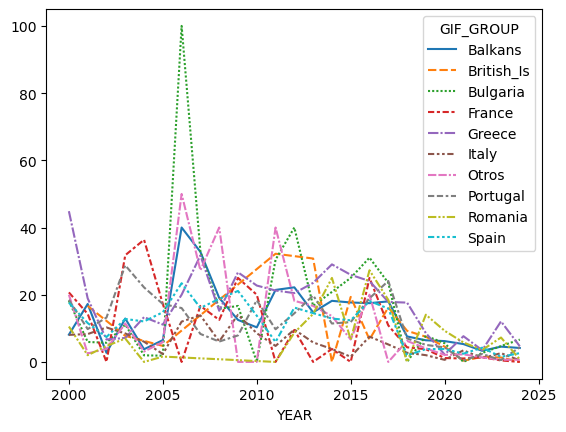

In [32]:
# Echamos un vistazo, y comprobamos que los porcentajes de GIFs
# disminuyen significativamente en todos los países a partir de 2017 (se aprecia muy bien en la tabla)

# Por tanto, esto significa que países como Rumanía, que han visto como el número de GIFs se incrementaba, 
# realmente es porque tienen una alta incidencia de incendios

# El porcentaje de superficie de los GIFs sigue manteniéndose, en general, en la misma franja de cada país

sns.lineplot(tabla_perc['count']);

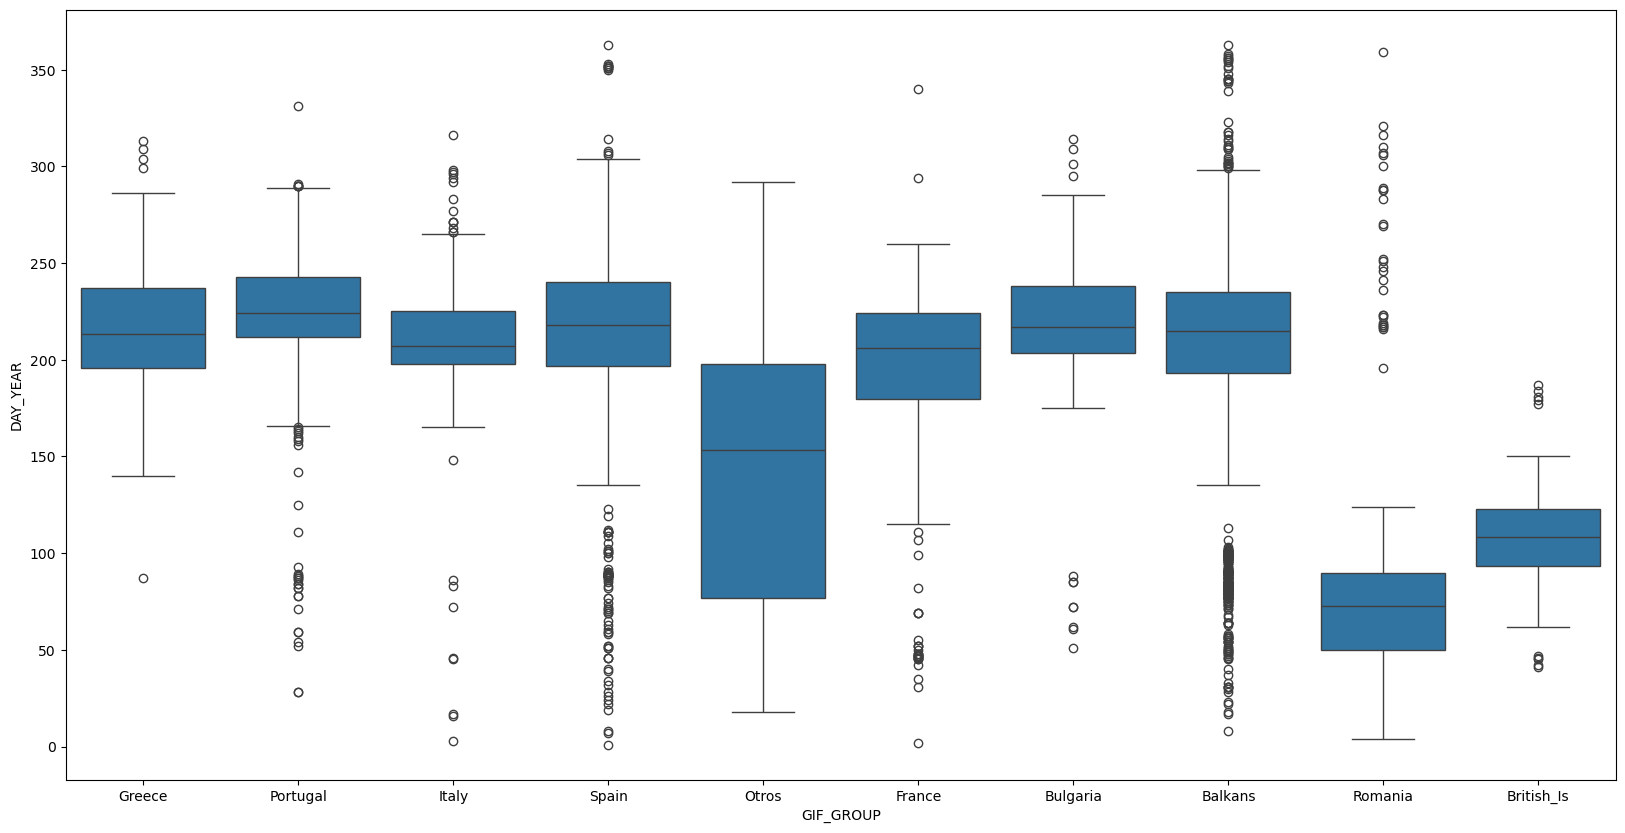

In [33]:
# Ahora intentaremos identificar las 'ventanas' de incidencia de los grande incendios forestales

plt.figure(figsize=(20, 10))
sns.boxplot(effis, x='GIF_GROUP', y='DAY_YEAR');

In [34]:
# Vamos a intentar  delimitar  el período de primavera
# Para ello, usaremos de modelo  a Rumanía e Islas Britanicas  frente  al resto de países 
# (a salvedad del grupo 'Otros' que quedará al margen debido a su amplitud)

std_epoca = effis.groupby('GIF_GROUP')['DAY_YEAR'].describe()
std_epoca['IQR'] = std_epoca['75%'] - std_epoca['25%']
std_epoca.sort_values('25%')

,count,mean,std,min,25%,50%,75%,max,IQR
GIF_GROUP,,,,,,,,,
Romania,184.0,94.673913,76.900064,4.0,49.75,72.5,89.50,359.0,39.75
Otros,108.0,144.481481,63.729346,18.0,77.00,153.5,198.00,292.0,121.00
British_Is,94.0,108.734043,27.674054,41.0,93.25,108.5,122.75,187.0,29.50
France,128.0,179.546875,72.789510,2.0,179.75,206.0,224.00,340.0,44.25
Balkans,1064.0,194.067669,67.815359,8.0,193.00,215.0,235.00,363.0,42.00
Greece,300.0,215.506667,27.986678,87.0,195.75,213.5,237.00,313.0,41.25
Spain,690.0,209.614493,58.571300,1.0,197.00,218.0,240.00,363.0,43.00
Italy,430.0,209.623256,32.689005,3.0,198.00,207.0,225.00,316.0,27.00
Bulgaria,148.0,215.216216,42.298026,51.0,203.75,217.0,238.00,314.0,34.25


In [35]:
# Establecemos los límites del período de grandes incendios en verano en función de Portugal, 
# que es el que tiene la distribución más retrasada además de contar con el mayor número de grandes incendios

pais_verano = std_epoca[std_epoca.index == 'Portugal']
lim_verano = [round(pais_verano['25%'].iloc[0] - 1.25*pais_verano['IQR'].iloc[0]),round(pais_verano['75%'].iloc[0] + 1.25*pais_verano['IQR'].iloc[0])]

lim_verano

[173, 282]

In [36]:
# Ahora vamos a ver la distribución de incendios fuera del período estival que hemos definido
# Para ello consideraremos los días un continuo desde 'otoño' hasta nuestro 'verano'

effis_inv = effis[(effis.DAY_YEAR < lim_verano[0]) | (effis.DAY_YEAR > lim_verano[1])]

def anti_juliano(dia):
    anti_dia = dia - 360 if dia > lim_verano[1] else dia
    return anti_dia

effis_inv.DAY_YEAR = effis_inv.DAY_YEAR.apply(anti_juliano)

/tmp/ipykernel_16370/1536153971.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  effis_inv.DAY_YEAR = effis_inv.DAY_YEAR.apply(anti_juliano)


,count,mean,std,min,25%,50%,75%,max,IQR
GIF_GROUP,,,,,,,,,
France,33.0,54.030303,39.948783,-66.0,46.0,48.0,69.00,170.0,23.00
British_Is,89.0,104.640449,22.136584,41.0,93.0,106.0,122.00,150.0,29.00
Romania,166.0,55.891566,37.790976,-77.0,46.0,61.0,82.75,124.0,36.75
Balkans,285.0,61.108772,47.223309,-74.0,51.0,81.0,90.00,135.0,39.00
Otros,66.0,98.515152,43.954257,-68.0,72.0,98.0,119.25,171.0,47.25
Bulgaria,13.0,21.538462,67.543338,-75.0,-51.0,61.0,72.00,88.0,123.00
Spain,169.0,47.846154,87.471900,-76.0,-57.0,69.0,111.00,172.0,168.00
Greece,18.0,98.166667,101.548163,-74.0,-13.5,159.0,168.00,172.0,181.50
Italy,23.0,54.565217,96.838115,-77.0,-53.0,46.0,166.50,172.0,219.50


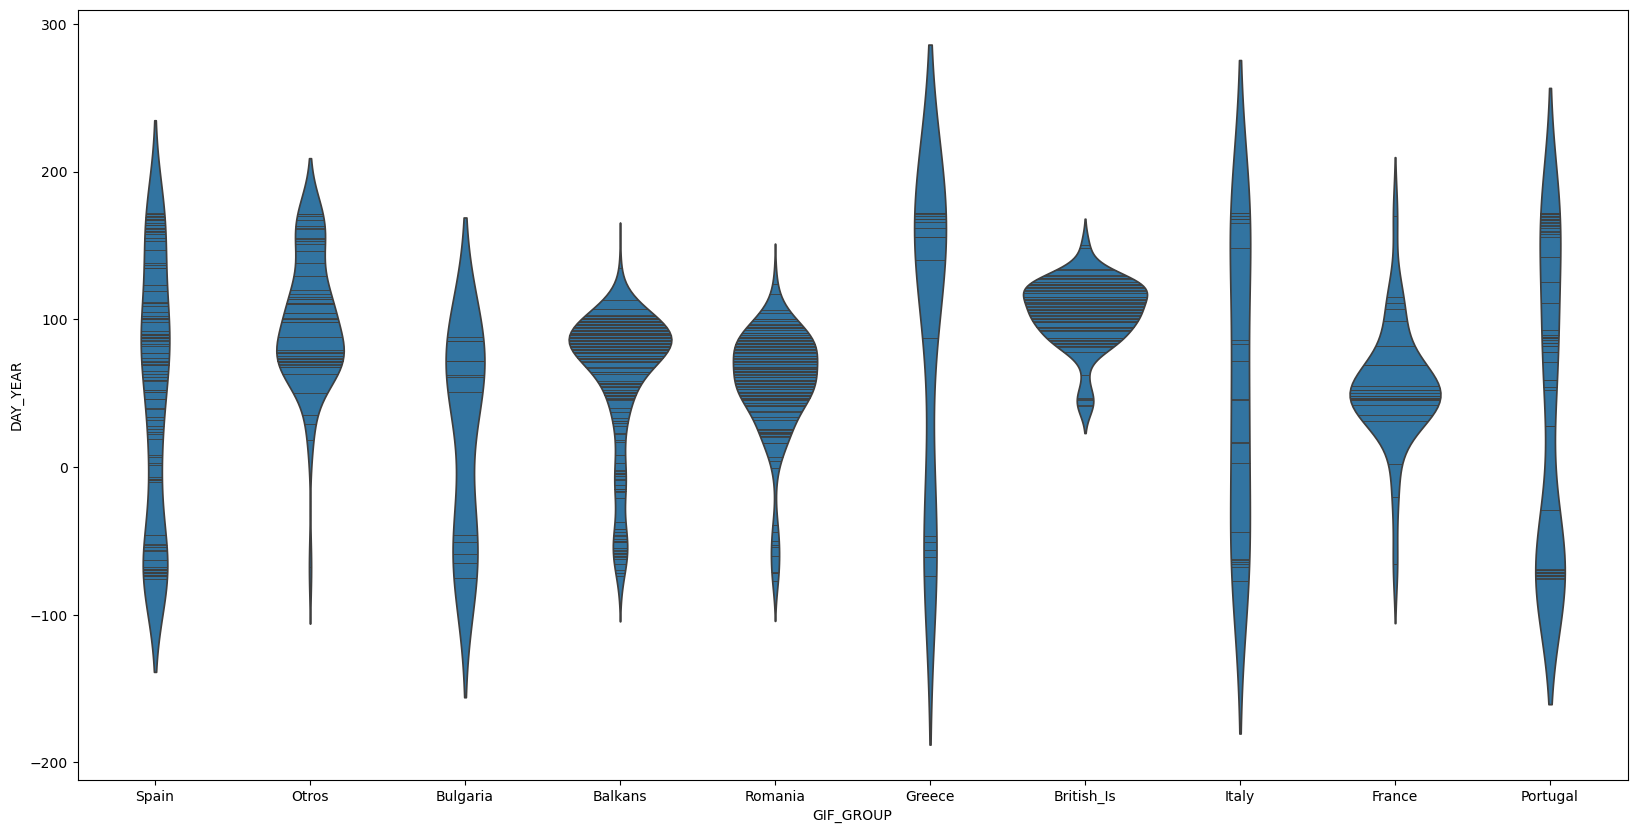

In [37]:
# En este caso, debido al menor numero de incendios y su distribución más homogénea en algunos casos, usaremos un diagrama de violin
# Podemos apreciar que los países de los Balcanes, Rumanía e Islas Británicas si tienen un período más marcado
# Además, son los países con mayor número de GIF en este período, salvo España y Portugal,
# los cuáles no tienen un período tan claro y sí un número mucho mayor de GIFs en general

plt.figure(figsize=(20, 10))
sns.violinplot(effis_inv, x='GIF_GROUP', y='DAY_YEAR', inner='sticks')
std_inv = effis_inv.groupby('GIF_GROUP')['DAY_YEAR'].describe()
std_inv['IQR'] = std_inv['75%'] - std_inv['25%']
std_inv.sort_values('IQR')

In [38]:
# Establecemos los límites del período de grandes incendios en invierno en función de Rumanía

pais_inv = std_epoca[std_epoca.index == 'Romania']
lim_inv = [round(pais_inv['25%'].iloc[0] - 1.25*pais_inv['IQR'].iloc[0]),round(pais_inv['75%'].iloc[0] + 1.25*pais_inv['IQR'].iloc[0])]

lim_inv

[0, 139]

In [39]:
# Comprobamos a qué días del calendario corresponden los días julianos calculados

def fecha_juliano(dia_juliano):
    dias_meses = [0,31,29,31,30,31,30,31,31,30,31,30]
    resto = dia_juliano
    for index, dias in enumerate(dias_meses):
        if resto - dias < 0:
            return f'{resto}/{index}'
            break
        resto = resto - dias

for string, dia in zip(['Inicio','Fin'],lim_verano):
    print(f'{string} verano:\t{fecha_juliano(dia)}')

for string, dia in zip(['Inicio','Fin'],lim_inv):
    print(f'{string} inv:\t{fecha_juliano(dia)}')

Inicio verano:	21/6
Fin verano:	8/10
Inicio inv:	0/1
Fin inv:	18/5


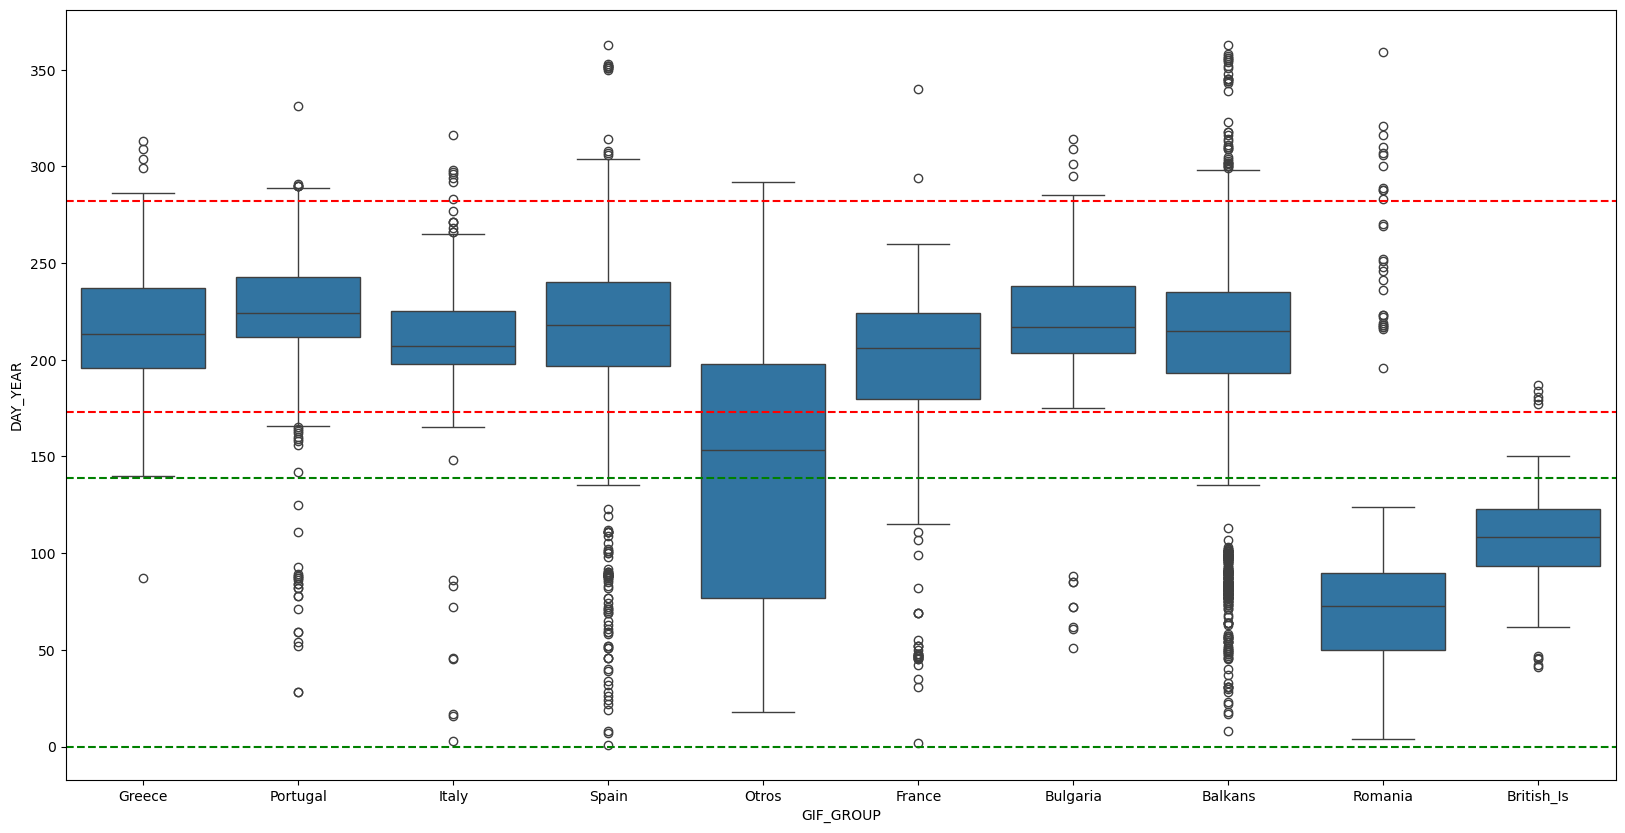

In [40]:
plt.figure(figsize=(20, 10))
sns.boxplot(effis, x='GIF_GROUP', y='DAY_YEAR')
plt.axhline(y=lim_verano[0], color='r', linestyle='--')
plt.axhline(y=lim_verano[1], color='r', linestyle='--')
plt.axhline(y=lim_inv[0], color='g', linestyle='--')
plt.axhline(y=lim_inv[1], color='g', linestyle='--');

In [66]:
# Ahora vamos a ver dónde se producen esos incendios estacionales
# Para ello primero los clasificamos según su día del año

effis['SEASON'] = 'Fall'
effis.loc[(effis.DAY_YEAR > lim_inv[1]) & (effis.DAY_YEAR < lim_verano[0]), 'SEASON'] = 'MayJun'
effis.loc[(effis.DAY_YEAR > lim_inv[0]) & (effis.DAY_YEAR < lim_inv[1]), 'SEASON'] = 'Spring'
effis.loc[(effis.DAY_YEAR > lim_verano[0]) & (effis.DAY_YEAR < lim_verano[1]), 'SEASON'] = 'Summer'

/tmp/ipykernel_16370/2669384336.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  effis['SEASON'] = 'Fall'


/tmp/ipykernel_16370/735718503.py:11: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(frameon=False)


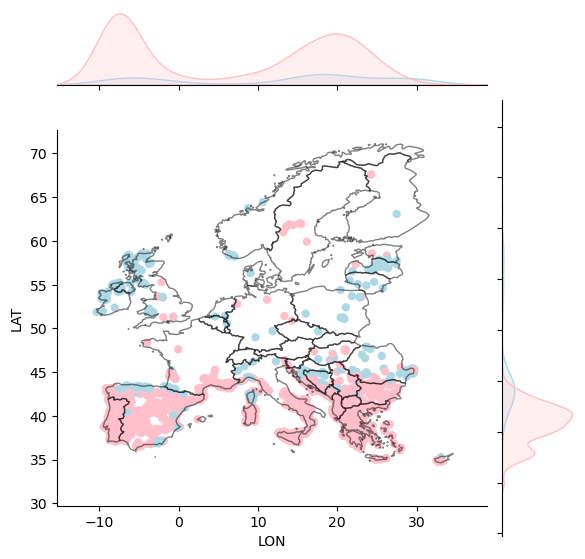

In [67]:
# Y ahora echamos un vistazo a su distribución
# Eliminamos de la muestra los incendios de Mayo-Junio y Otoño para simplificar 

g = sns.jointplot(effis, x='LON', y='LAT', hue = 'SEASON', palette={'Spring':'lightblue','Summer':'pink', 'MayJun':'none','Fall':'none'}, edgecolor='none', legend=False)

# Ajustamos para agregar el mapa de los países de fondo
ax = g.ax_joint
zoom = 5
ax.set_xlim(effis.LON.min() - zoom, effis.LON.max() + zoom)
ax.set_ylim(effis.LAT.min() - zoom, effis.LAT.max() + zoom)
ax.legend(frameon=False)

# Agregamos el shapefile directamente desde geopandas
df_paises.plot(ax=ax, color='none', edgecolor='k', alpha=0.5);

**EVOLUCIÓN DEL PERÍODO DE INCENDIOS**  
Ahora comprobaremos si esta 'ventana' de grandes incenduios siempre ha sido la misma o ha ido cambiando.

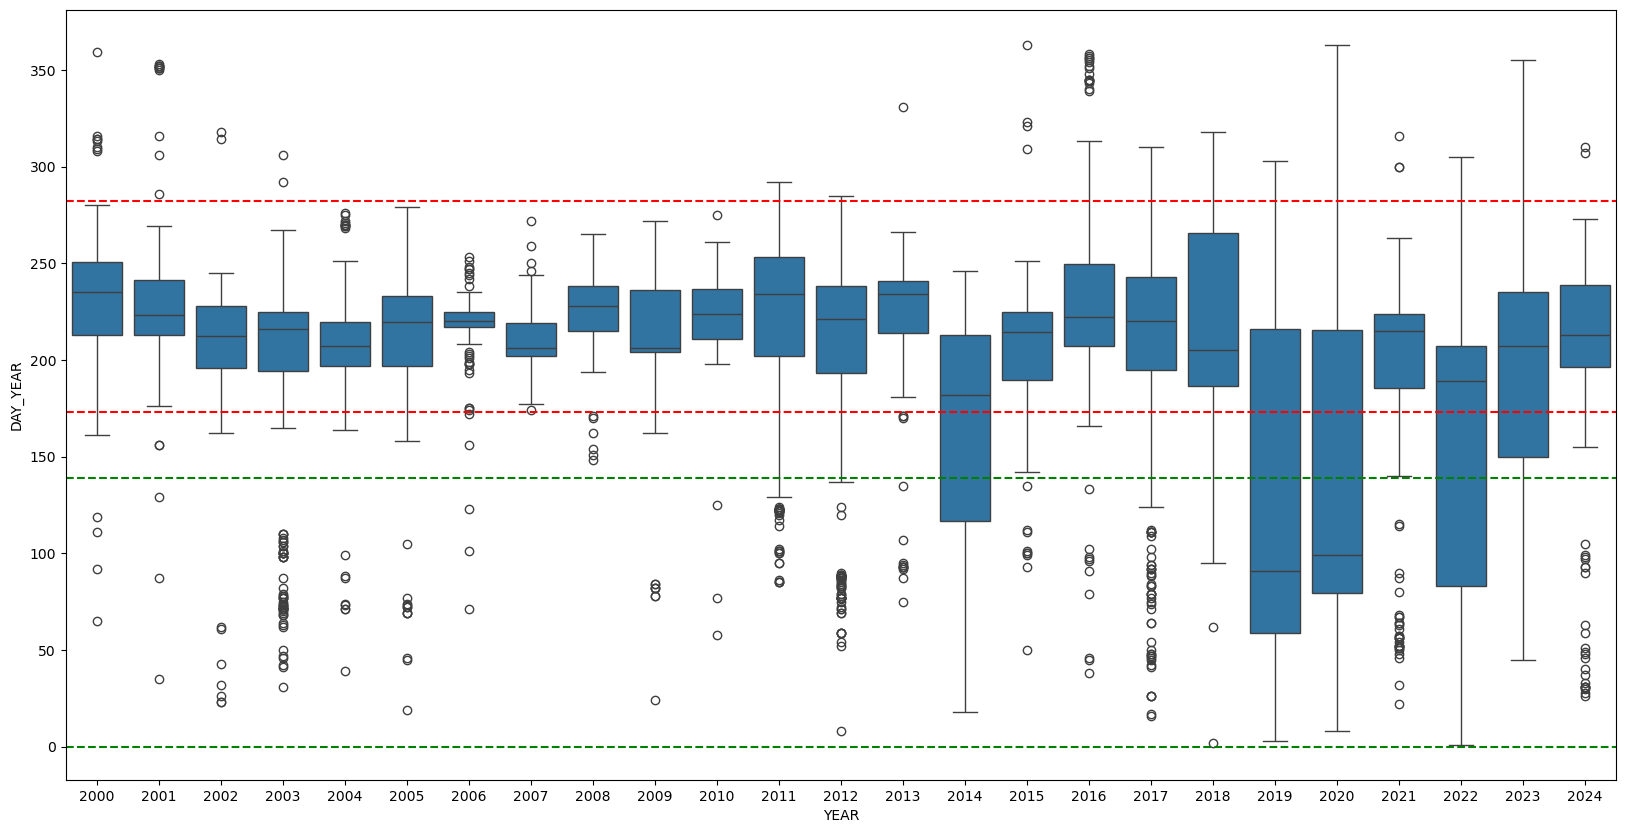

In [68]:
# Distribución de número de grandes incendios por día juliano para cada año
# Aquí podemos ver cómo la ventana de los grandes incendios se va ampliando hacia la primavera

plt.figure(figsize=(20, 10))
sns.boxplot(effis, x='YEAR', y='DAY_YEAR')
plt.axhline(y=lim_verano[0], color='r', linestyle='--')
plt.axhline(y=lim_verano[1], color='r', linestyle='--')
plt.axhline(y=lim_inv[0], color='g', linestyle='--')
plt.axhline(y=lim_inv[1], color='g', linestyle='--');

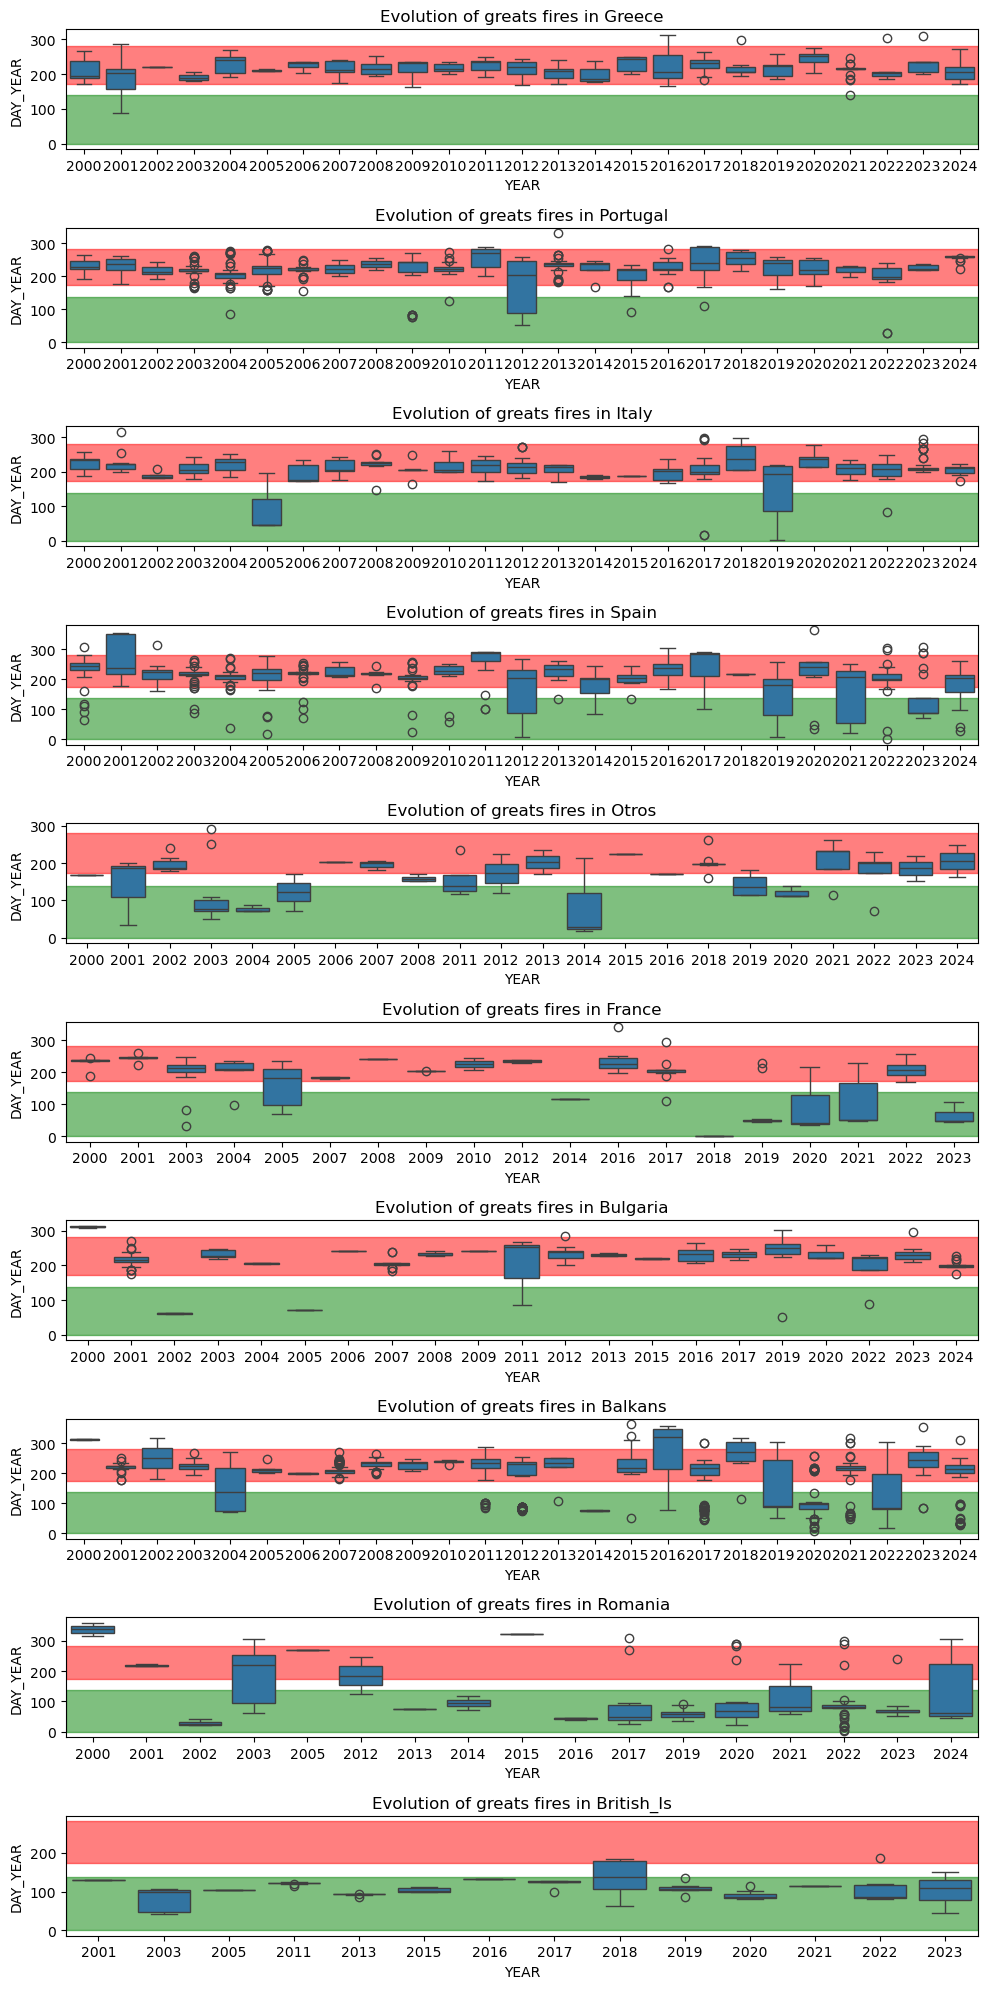

In [69]:
def pinta_catbox(df, cat):
    variables = df[cat].unique()
    fig, axs = plt.subplots(len(variables),1, figsize=(10,20))

    for index, variable in enumerate(variables):
        filtro = df[df[cat] == variable]
        sns.boxplot(filtro, x='YEAR', y='DAY_YEAR', ax=axs[index])
        axs[index].axhspan(lim_verano[0], lim_verano[1], color='r', alpha=0.5)
        axs[index].axhspan(lim_inv[0], lim_inv[1], color='g', alpha=0.5)
        axs[index].set_title(f'Evolution of greats fires in {variable}')
    fig.tight_layout()

pinta_catbox(effis, 'GIF_GROUP')

**BUSCANDO LOS MÁS GRANDES**  
En este apartado comprobaremos si hay alguna época predilecta, alguna zona y/o alguna tendencia relacionada con el área quemada

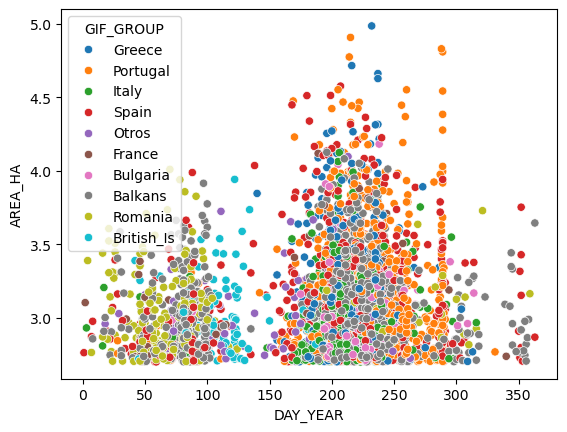

In [70]:
# Ahora comprobemos cuándo se producen los incendios más grandes
# Como se puede apreciar, no parece que haya relación con las fechas (más alá de lo obvio, en verano hay más incendios y más grandes)
# Sin embargo, sí se aprecian los dos períodos previamente definidos (más algunos outliers en diciembre)

sns.scatterplot(effis, x='DAY_YEAR', y=np.log10(effis.AREA_HA), hue='GIF_GROUP');

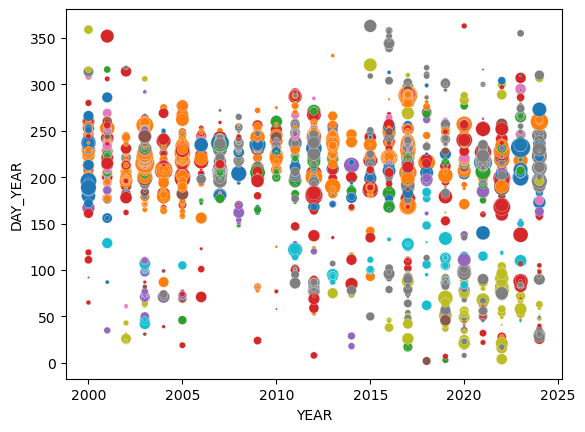

In [71]:
# De nuevo, comparemos la evolución de los grandes incendios en función de los días julianos y por grupo de países
# Volvemos a apreciar esa tendencia de incendios de primavera en Rumanía, Balcanes e Islas Británicas,
# aumentando además el tamaño de los mismos en estas zonas

sns.scatterplot(effis, y='DAY_YEAR', x='YEAR', size=np.log10(effis.AREA_HA),sizes=(2, 200), hue='GIF_GROUP', legend=False);

Ahora nos centraremos en el área quemada:
- Primero en la suma de las áreas, que aunque parece haber cierta tendencia al alza, realmente podrían asociarse a hechos aislados,  
como Portugal 2017 (Pedro Gao) y Grecia (2021 y 2023 con Alexandropolis) y España en 2022.
- Si observamos el tamaño medio de los grandes incendios, aunque parece que éstos se mantienen con el tiempo, salvando años puntuales (Rumania, España, Grecia),  
sí se observa una tendencia a hechos singulares, reflejado en un aumento paulatino de la media del área quemada  

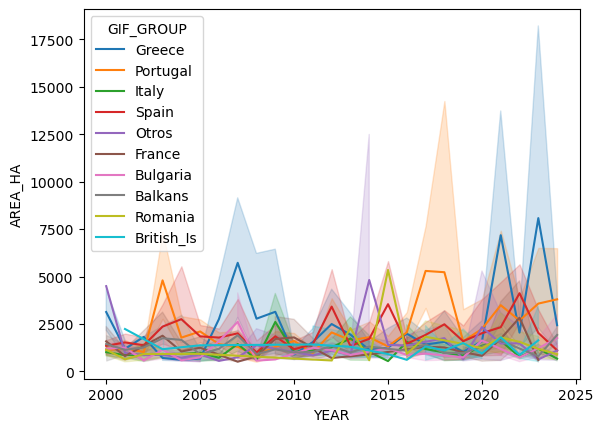

In [72]:
sns.lineplot(effis, x='YEAR', y='AREA_HA', hue='GIF_GROUP');

In [73]:
# Veamos por un momento las estadísticas del área quemada 

median_size = effis.groupby(['GIF_GROUP','YEAR'])['AREA_HA'].describe().reset_index()
median_size

,GIF_GROUP,YEAR,count,mean,std,min,25%,50%,75%,max
0,Balkans,2000,3.0,1447.333333,753.632094,578.0,1213.00,1848.0,1882.00,1916.0
1,Balkans,2001,30.0,1139.366667,763.342490,532.0,686.00,873.0,1261.00,4129.0
2,Balkans,2002,2.0,1264.000000,882.469263,640.0,952.00,1264.0,1576.00,1888.0
3,Balkans,2003,47.0,1749.744681,2088.359117,505.0,636.00,889.0,1456.50,10442.0
4,Balkans,2004,4.0,1663.750000,1355.153466,724.0,903.25,1133.0,1893.50,3665.0
...,...,...,...,...,...,...,...,...,...,...
213,Spain,2020,18.0,2015.388889,3789.721178,509.0,618.75,734.5,1503.25,16758.0
214,Spain,2021,22.0,2331.454545,4982.787064,525.0,600.25,812.5,1402.00,23078.0
215,Spain,2022,63.0,4121.746032,6275.104078,505.0,892.50,1645.0,3359.00,32528.0
216,Spain,2023,21.0,2031.904762,2909.860631,509.0,582.00,973.0,1448.00,10843.0


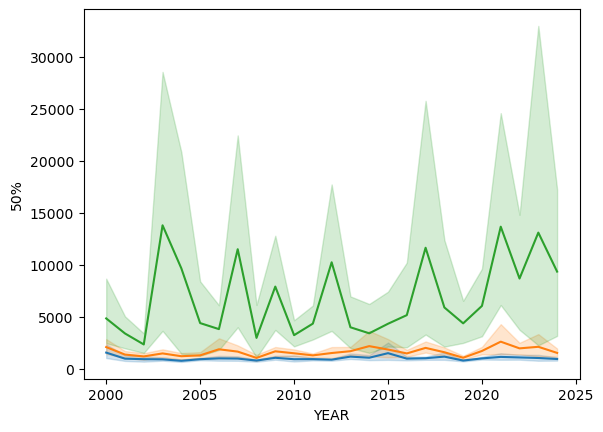

In [74]:
# Si nos fijamos en los valores medios de los quartiles y los comparamos con la superficie máxima de cada año
# vemos que la diferencia de superficies es abismal, es decir, tenemos incendios puntuales que destacan en tamaño  

sns.lineplot(median_size, x='YEAR', y='50%')
sns.lineplot(median_size, x='YEAR', y='75%')
sns.lineplot(median_size, x='YEAR', y='max');

Por último un resumen de la evolución del tamaño de los grandes incendios y su número por país.

In [75]:
# Primero categorizamos para ver la distribución de forma más clara

effis['AREA_CAT'] = 6
effis.loc[effis.AREA_HA<40000, 'AREA_CAT'] = 5
effis.loc[effis.AREA_HA<20000, 'AREA_CAT'] = 4
effis.loc[effis.AREA_HA<10000, 'AREA_CAT'] = 3
effis.loc[effis.AREA_HA<5000, 'AREA_CAT'] = 2
effis.loc[effis.AREA_HA<2500, 'AREA_CAT'] = 1

/tmp/ipykernel_16370/1133877605.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  effis['AREA_CAT'] = 6


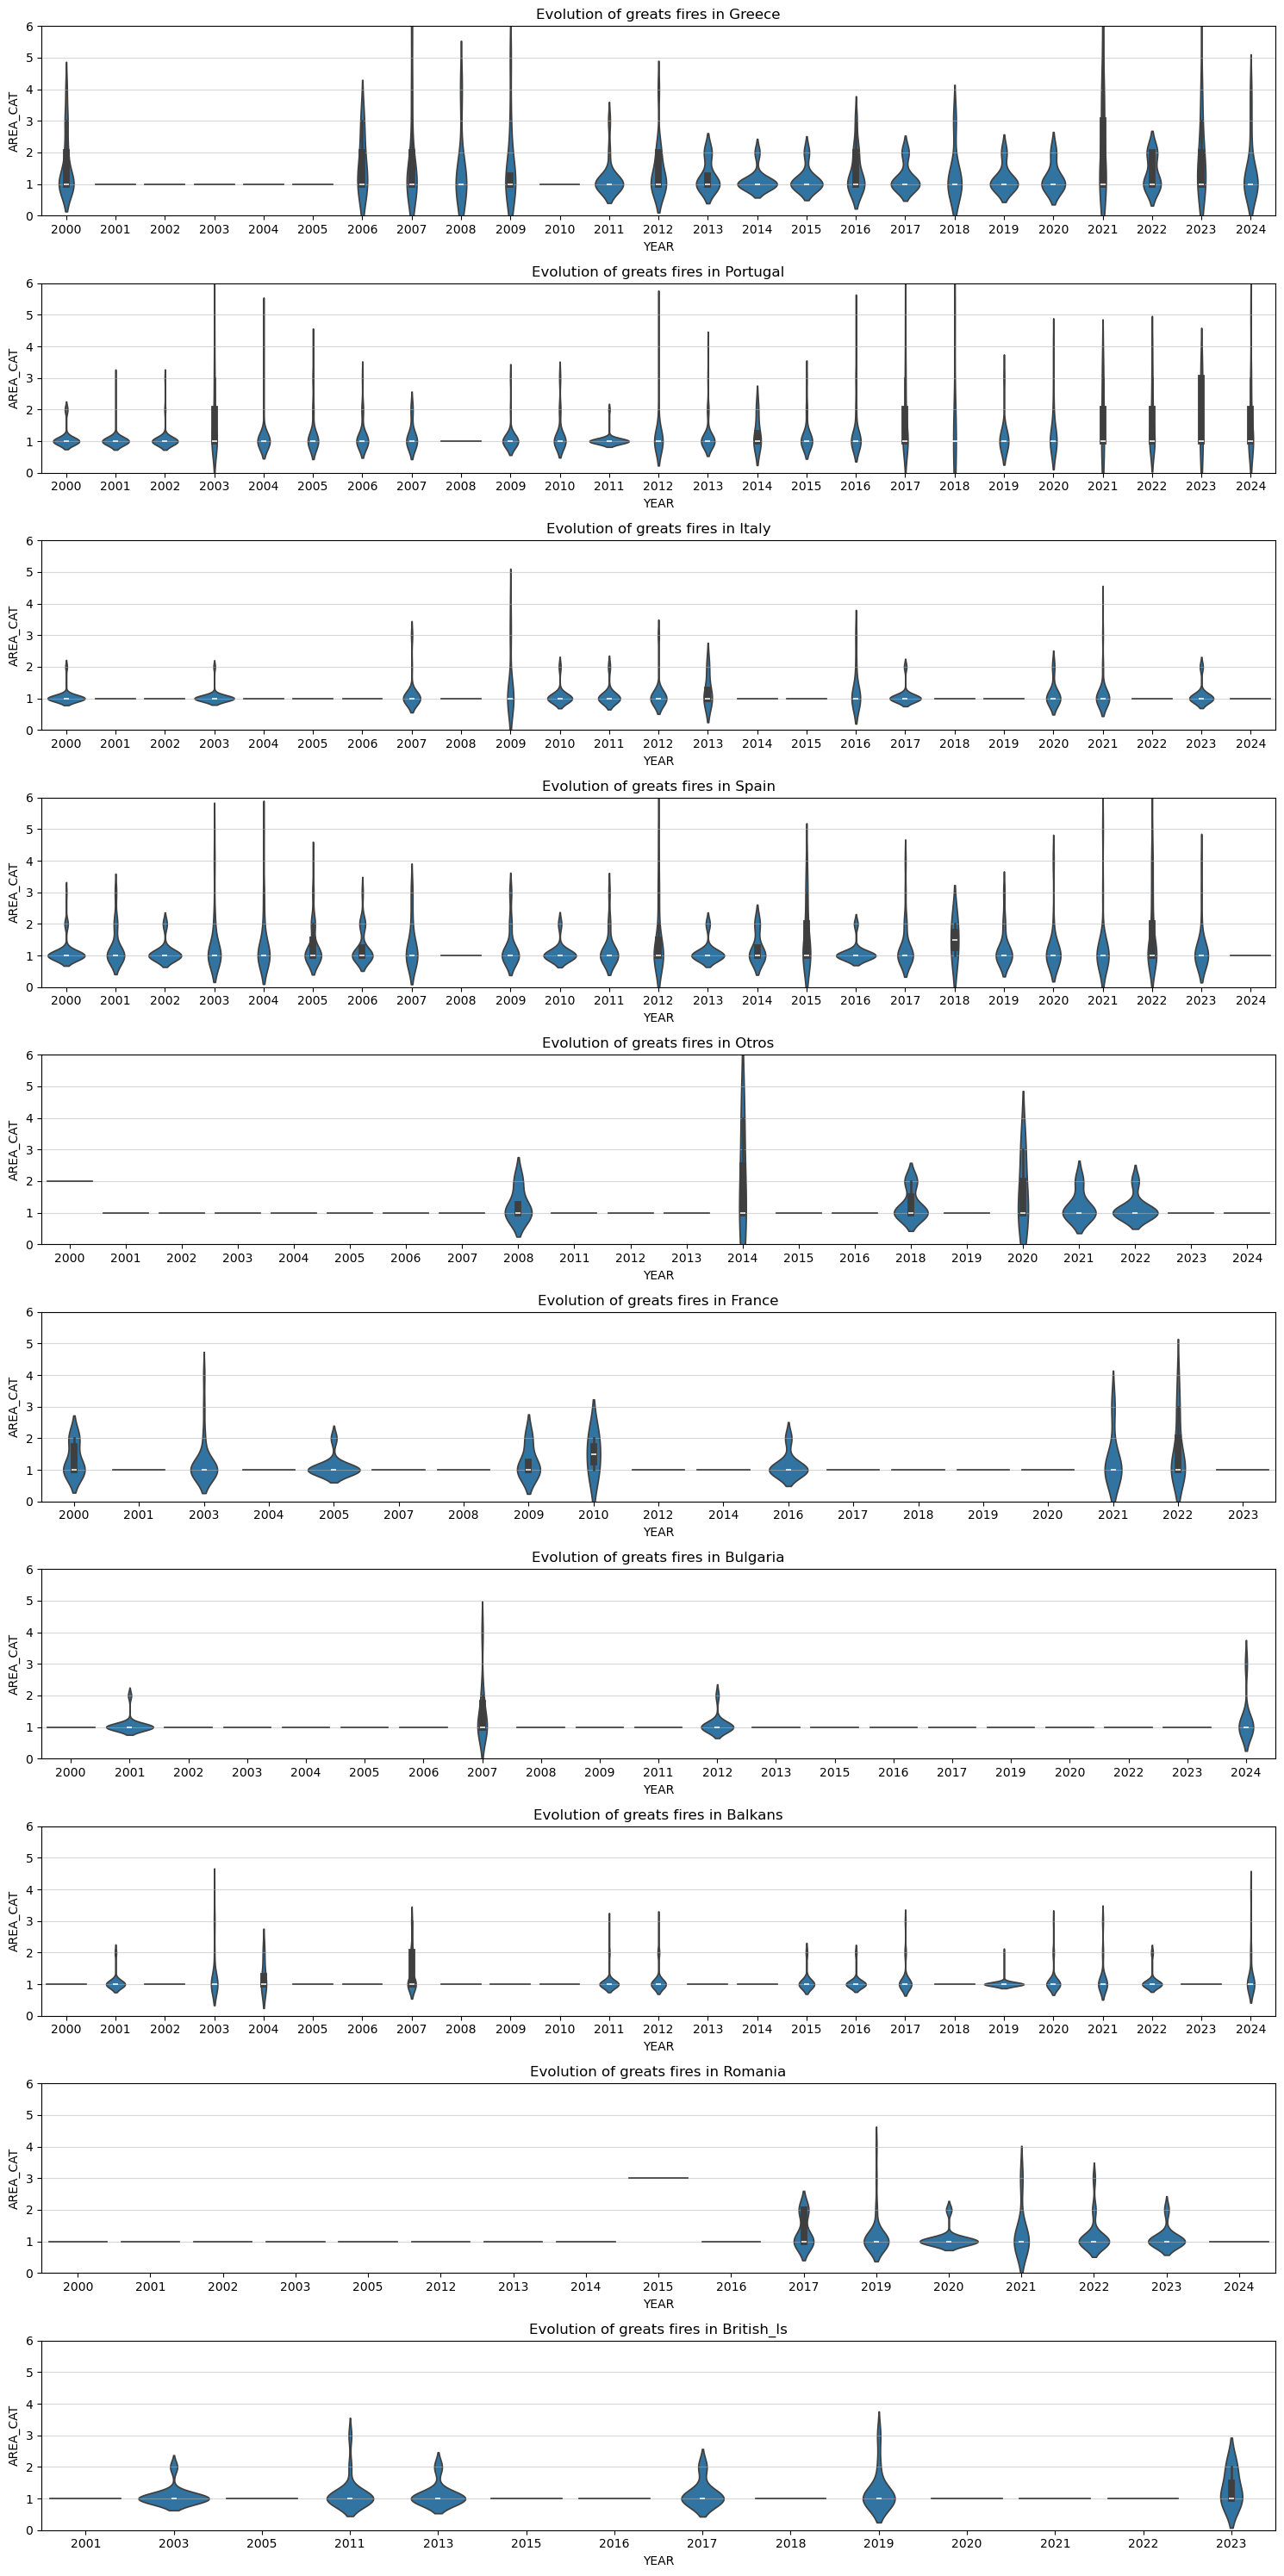

In [76]:
def pinta_catviolin(df, cat):
    variables = df[cat].unique()
    fig, axs = plt.subplots(len(variables),1, figsize=(15,30))

    for index, variable in enumerate(variables):
        filtro = df[df[cat] == variable]
        sns.violinplot(filtro, x='YEAR', y='AREA_CAT', ax=axs[index])
        axs[index].set_title(f'Evolution of greats fires in {variable}')
        axs[index].set_ylim(0,6)
        axs[index].grid(axis='y', alpha=0.5)
    fig.tight_layout()

pinta_catviolin(effis, 'GIF_GROUP')

Tras comprobar que no parece que haya una evolución clara del tamaño de los grandes incendios (salvo unos últimos malos años en Grecia y Portugal)  
continuaremos centrándonos en top 30 de los grandes incendios (todos ellos superando las 20,000 ha)

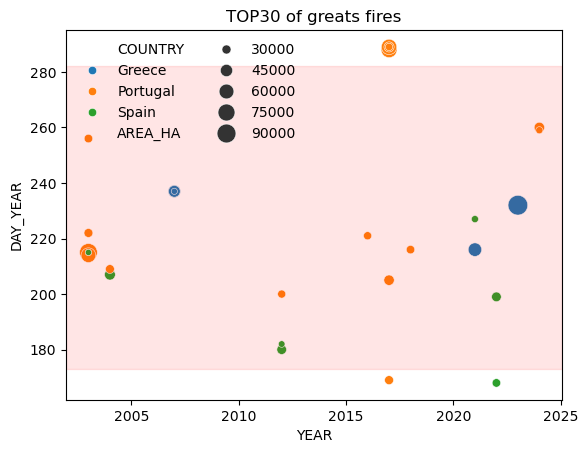

In [77]:
# De nuevo observamos que no hay ningún patrón observable, fuera de años malos en el país de turno
# Tampoco se ve ningún patrón marcado en cuanto a la época del año, sólo destacan los incendios de 2017 en Portugal, fuera del período de verano 

top30 = effis.nlargest(30,'AREA_HA')[['YEAR','DAY_YEAR','AREA_HA','COUNTRY','PROVINCE']].reset_index()

g = sns.scatterplot(top30, x='YEAR', y='DAY_YEAR', size='AREA_HA', sizes=(20,200), hue='COUNTRY')
g.axhspan(lim_verano[0], lim_verano[1], color='r', alpha=0.1)
#g.axhspan(lim_inv[0], lim_inv[1], color='g', alpha=0.1)
g.legend(loc='best', ncols=2, frameon=False)
g.set_title(f'TOP30 of greats fires');